##### Copyright 2024 The AI Edge Authors.

In [10]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# On-Device Training with TensorFlow Lite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/examples/on_device_training/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

When deploying a TensorFlow Lite machine learning model on an edge device or mobile app, you may want to enable the model to be improved or personalized based on input from the device or end user. Using on-device training techniques allows you to update a model *without* data leaving your users' devices, improving user privacy, and without requiring users to update the device software.

For example, you may have a model in your mobile app that recognizes fashion items, but you want users to get improved recognition performance over time based on their interests. Enabling on-device training allows users who are interested in shoes to get better at recognizing a particular style of shoe or shoe brand the more often they use your app.

This tutorial shows you how to construct a TensorFlow Lite model that can be incrementally trained and improved within an installed Android app.

Note: The on-device training technique can be added to existing TensorFlow Lite implementations, provided the devices you are targeting support local file storage.


## Setup

This tutorial uses Python to train and convert a TensorFlow model before incorporating it into an Android app. Get started by installing and importing the following packages.

In [ ]:
#Requirements
%pip install --upgrade pip
%pip install protobuf==3.20.3
%pip install matplotlib==3.9.4
%pip install numpy==1.23.5
%pip install tensorflow==2.8.0

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


Note: The On-Device Training APIs are available in TensorFlow version 2.7 and higher.

## Classify images of clothing

This example code uses the [Fashion MNIST dataset](https://keras.io/api/datasets/fashion_mnist/) to train a neural network model for classifying images of clothing. This dataset contains 60,000 small (28 x 28 pixel) grayscale images containing 10 different categories of fashion accessories, including dresses, shirts, and sandals.

<figure>
  <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
       alt="Fashion MNIST images">
  <figcaption><b>Figure 1</b>: <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).</figcaption>
</figure>

You can explore this dataset in more depth in the [Keras classification tutorial](https://www.tensorflow.org/tutorials/keras/classification#import_the_fashion_mnist_dataset).

## Build a model for on-device training

TensorFlow Lite models typically have only a single exposed function method (or [signature](https://www.tensorflow.org/lite/guide/signatures)) that allows you to call the model to run an inference. For a model to be trained and used on a device, you must be able to perform several separate operations, including train, infer, save, and restore functions for the model. You can enable this functionality by first extending your TensorFlow model to have multiple functions, and then exposing those functions as signatures when you convert your model to the TensorFlow Lite model format.

The code example below shows you how to add the following functions to a TensorFlow model:

*   `train` function trains the model with training data.
*   `infer` function invokes the inference.
*   `save` function saves the trainable weights into the file system.
*   `restore` function loads the trainable weights from the file system.

In [13]:
IMG_SIZE = 28

class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE), name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(10, name='dense_2')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self.model.loss(y, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    return result

  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
  ])
  def infer(self, x):
    logits = self.model(x)
    probabilities = tf.nn.softmax(logits, axis=-1)
    return {
        "output": probabilities,
        "logits": logits
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

The `train` function in the code above uses the [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) class to record operations for automatic differentiation. For more information on how to use this class, see the [Introduction to gradients and automatic differentiation](https://www.tensorflow.org/guide/autodiff).

You could use the `Model.train_step` method of the keras model here instead of a from-scratch implementation. Just note that the loss (and metrics) returned by `Model.train_step` is the running average, and should be reset regularly (typically each epoch). See [Customize Model.fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Note: The weights generated by this model are serialized into a TensorFlow 1 format checkpoint file.

## Prepare the data

Get the Fashion MNIST dataset for training your model.

In [14]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### Preprocess the dataset

Pixel values in this dataset are between 0 and 255, and must be normalized to a value between 0 and 1 for processing by the model. Divide the values by 255 to make this adjustment.

In [15]:
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

Convert the data labels to categorical values by performing one-hot encoding.

In [16]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

Note: Make sure to preprocess your *training* and *testing* datasets in the same way so that your testing can accurately evaluate your model's performance.

## Train the model

Before converting and setting up your TensorFlow Lite model, complete the initial training of your model using the preprocessed dataset and the `train` signature method. The following code runs model training for 100 epochs, processing batches of 100 images at a time, and displaying the loss value after every 10 epochs. Since this training run is processing quite a bit of data, it may take a few minutes to finish.


In [17]:
NUM_EPOCHS = 100
BATCH_SIZE = 100
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('./tmp/model.ckpt')

Finished 10 epochs
  loss: 0.409
Finished 20 epochs
  loss: 0.356
Finished 30 epochs
  loss: 0.322
Finished 40 epochs
  loss: 0.298
Finished 50 epochs
  loss: 0.280
Finished 60 epochs
  loss: 0.266
Finished 70 epochs
  loss: 0.255
Finished 80 epochs
  loss: 0.244
Finished 90 epochs
  loss: 0.236
Finished 100 epochs
  loss: 0.229


{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'./tmp/model.ckpt'>}

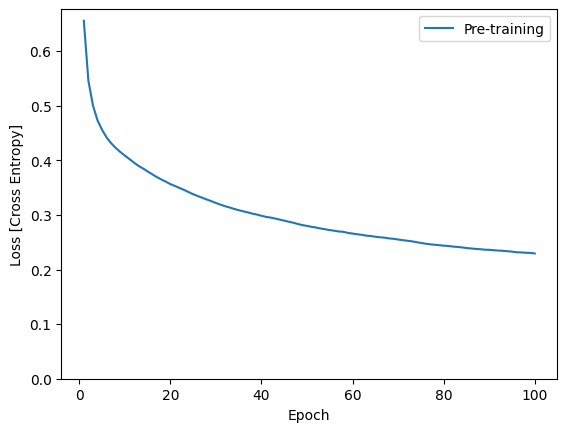

In [18]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

Note: You should complete the initial training of your model before converting it to TensorFlow Lite format, so that the model has an initial set of weights, and is able to perform reasonable inferences *before* you start collecting data and conducting training runs on the device.

## Convert model to TensorFlow Lite format

After you have extended your TensorFlow model to enable additional functions for on-device training and completed the initial training of the model, you can convert it to TensorFlow Lite format. The following code converts and saves your model to that format, including the set of signatures that you use with the TensorFlow Lite model on a device: `train, infer, save, restore`.

In [19]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_model\assets


### Setup the TensorFlow Lite signatures

The TensorFlow Lite model you saved in the previous step contains several function signatures. You can access them through the `tf.lite.Interpreter` class and invoke each `restore`, `train`, `save`, and `infer` signature separately.

In [20]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

Compare the output of the original model, and the converted lite model:

In [21]:
logits_original = m.infer(x=train_images[:1])['logits'][0]
logits_lite = infer(x=train_images[:1])['logits'][0]

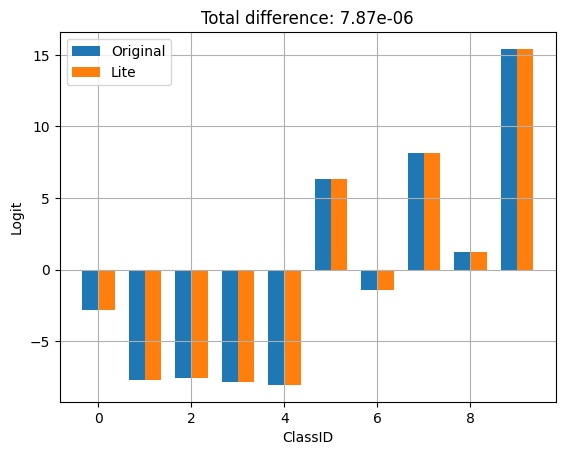

In [22]:
#@title
def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

compare_logits({'Original': logits_original, 'Lite': logits_lite})

Above, you can see that the behavior of the model is not changed by the conversion to TFLite.

## Retrain the model on a device

After converting your model to TensorFlow Lite and deploying it with your app, you can retrain the model on a device using new data and the `train` signature method of your model. Each training run generates a new set of weights that you can save for re-use and further improvement of the model, as shown in the next section.

Note: Since training tasks are resource intensive, you should consider performing them when users are not actively interacting with the device, and as a background process. Consider using the [WorkManager](https://developer.android.com/topic/libraries/architecture/workmanager) API to schedule model retraining as an asynchronous task.

On Android, you can perform on-device training with TensorFlow Lite using either Java or C++ APIs. In Java, use the `Interpreter` class to load a model and drive model training tasks. The following example shows how to run the training procedure using the `runSignature` method:


```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    int NUM_EPOCHS = 100;
    int BATCH_SIZE = 100;
    int IMG_HEIGHT = 28;
    int IMG_WIDTH = 28;
    int NUM_TRAININGS = 60000;
    int NUM_BATCHES = NUM_TRAININGS / BATCH_SIZE;

    List<FloatBuffer> trainImageBatches = new ArrayList<>(NUM_BATCHES);
    List<FloatBuffer> trainLabelBatches = new ArrayList<>(NUM_BATCHES);

    // Prepare training batches.
    for (int i = 0; i < NUM_BATCHES; ++i) {
        FloatBuffer trainImages = FloatBuffer.allocateDirect(BATCH_SIZE * IMG_HEIGHT * IMG_WIDTH).order(ByteOrder.nativeOrder());
        FloatBuffer trainLabels = FloatBuffer.allocateDirect(BATCH_SIZE * 10).order(ByteOrder.nativeOrder());

        // Fill the data values...
        trainImageBatches.add(trainImages.rewind());
        trainImageLabels.add(trainLabels.rewind());
    }

    // Run training for a few steps.
    float[] losses = new float[NUM_EPOCHS];
    for (int epoch = 0; epoch < NUM_EPOCHS; ++epoch) {
        for (int batchIdx = 0; batchIdx < NUM_BATCHES; ++batchIdx) {
            Map<String, Object> inputs = new HashMap<>();
            inputs.put("x", trainImageBatches.get(batchIdx));
            inputs.put("y", trainLabelBatches.get(batchIdx));

            Map<String, Object> outputs = new HashMap<>();
            FloatBuffer loss = FloatBuffer.allocate(1);
            outputs.put("loss", loss);

            interpreter.runSignature(inputs, outputs, "train");

            // Record the last loss.
            if (batchIdx == NUM_BATCHES - 1) losses[epoch] = loss.get(0);
        }

        // Print the loss output for every 10 epochs.
        if ((epoch + 1) % 10 == 0) {
            System.out.println(
              "Finished " + (epoch + 1) + " epochs, current loss: " + loss.get(0));
        }
    }

    // ...
}
```


You can see a complete code example of model retraining inside an Android app in the [model personalization demo app](https://github.com/tensorflow/examples/blob/master/lite/examples/model_personalization/android/transfer_api/src/main/java/org/tensorflow/lite/examples/transfer/api/LiteMultipleSignatureModel.java).

Run training for a few epochs to improve or personalize the model. In practice, you would run this additional training using data collected on the device. For simplicity, this example uses the same training data as the previous training step.

In [23]:
train = interpreter.get_signature_runner("train")

NUM_EPOCHS = 50
BATCH_SIZE = 100
more_epochs = np.arange(epochs[-1]+1, epochs[-1] + NUM_EPOCHS + 1, 1)
more_losses = np.zeros([NUM_EPOCHS])


for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = train(x=x, y=y)
  more_losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {more_losses[i]:.3f}")

Finished 10 epochs
  loss: 0.225
Finished 20 epochs
  loss: 0.222
Finished 30 epochs
  loss: 0.219
Finished 40 epochs
  loss: 0.217
Finished 50 epochs
  loss: 0.213


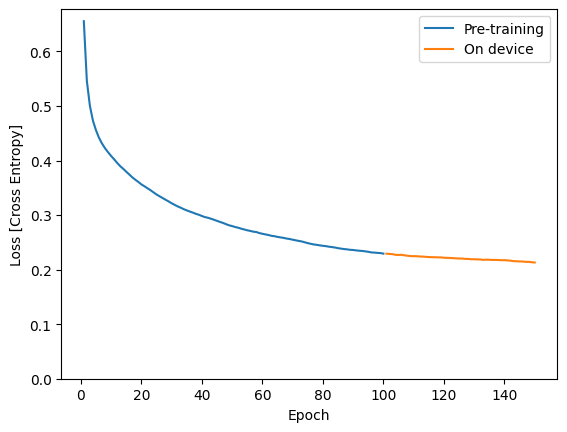

In [24]:
plt.plot(epochs, losses, label='Pre-training')
plt.plot(more_epochs, more_losses, label='On device')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

Above you can see that the on-device training picks up exactly where the pretraining stopped.

## Save the trained weights

When you complete a training run on a device, the model updates the set of weights it is using in memory. Using the `save` signature method you created in your TensorFlow Lite model, you can save these weights to a checkpoint file for later reuse and improve your model.

In [25]:
save = interpreter.get_signature_runner("save")

save(checkpoint_path=np.array("./tmp/model.ckpt", dtype=np.string_))

{'checkpoint_path': array(b'./tmp/model.ckpt', dtype=object)}

In your Android application, you can store the generated weights as a checkpoint file in the internal storage space allocated for your app.

```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    // Conduct the training jobs.

    // Export the trained weights as a checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    interpreter.runSignature(inputs, outputs, "save");
}
```

## Restore the trained weights

Any time you create an interpreter from a TFLite model, the interpreter will initially load the original model weights.

So after you've done some training and saved a checkpoint file, you'll need to run the `restore` signature method to load the checkpoint.

A good rule is "Anytime you create an Interpreter for a model, if the checkpoint exists, load it". If you need to reset the model to the baseline behavior, just delete the checkpoint and create a fresh interpreter.


In [26]:
another_interpreter = tf.lite.Interpreter(model_content=tflite_model)
another_interpreter.allocate_tensors()

infer = another_interpreter.get_signature_runner("infer")
restore = another_interpreter.get_signature_runner("restore")

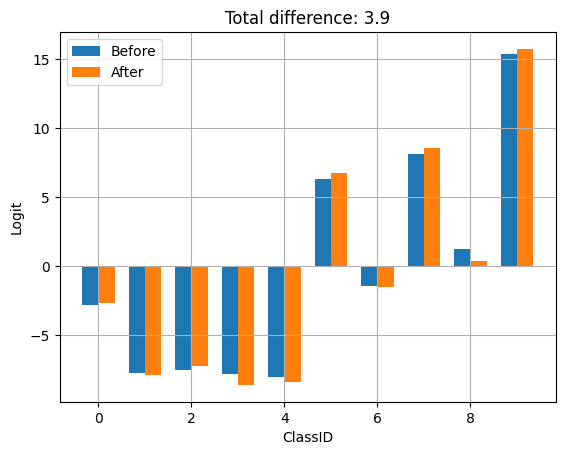

In [27]:
logits_before = infer(x=train_images[:1])['logits'][0]

# Restore the trained weights from /tmp/model.ckpt
restore(checkpoint_path=np.array("./tmp/model.ckpt", dtype=np.string_))

logits_after = infer(x=train_images[:1])['logits'][0]

compare_logits({'Before': logits_before, 'After': logits_after})

The checkpoint was generated by training and saving with TFLite. Above you can see that applying the checkpoint updates the behavior of the model.

Note: Loading the saved weights from the checkpoint can take time, based on the number of variables in the model and the size of the checkpoint file.


In your Android app, you can restore the serialized, trained weights from the checkpoint file you stored earlier.

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Load the trained weights from the checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    anotherInterpreter.runSignature(inputs, outputs, "restore");
}
```

Note: When your application restarts, you should reload your trained weights prior to running new inferences.

## Run Inference using trained weights

Once you have loaded previously saved weights from a checkpoint file, running the `infer` method uses those weights with your original model to improve predictions. After loading the saved weights, you can use the `infer` signature method as shown below.

Note: Loading the saved weights is not required to run an inference, but running in that configuration produces predictions using the originally trained model, without improvements.

In [28]:
infer = another_interpreter.get_signature_runner("infer")
result = infer(x=test_images)
predictions = np.argmax(result["output"], axis=1)

true_labels = np.argmax(test_labels, axis=1)

In [29]:
result['output'].shape

(10000, 10)

Plot the predicted labels.

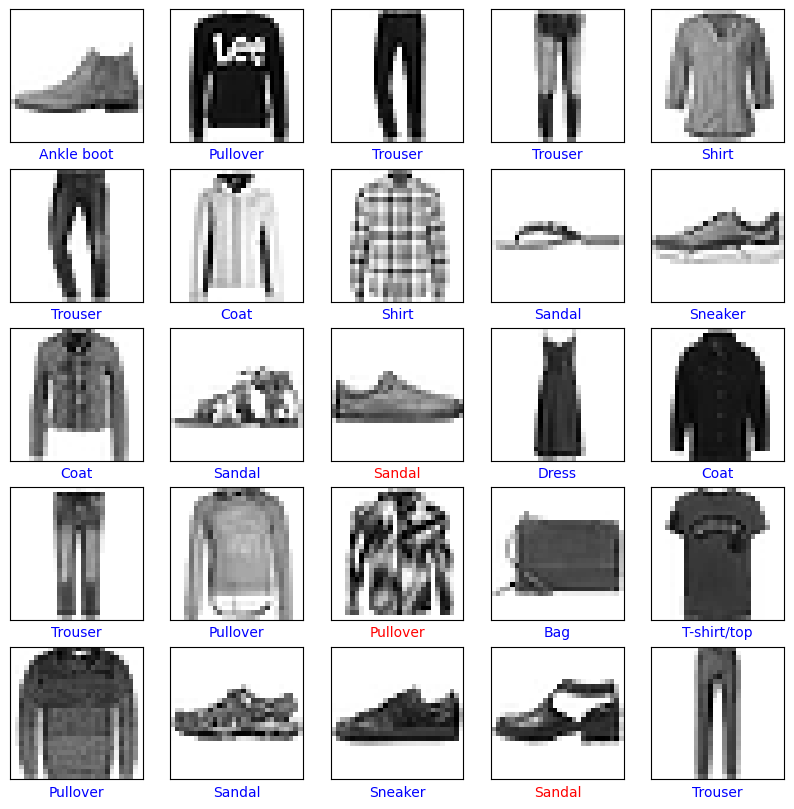

In [30]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot(images, predictions, true_labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      color = 'b' if predictions[i] == true_labels[i] else 'r'
      plt.xlabel(class_names[predictions[i]], color=color)
  plt.show()

plot(test_images, predictions, true_labels)

In [31]:
predictions.shape

(10000,)

In your Android application, after restoring the trained weights, run the inferences based on the loaded data.

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Restore the weights from the checkpoint file.

    int NUM_TESTS = 10;
    FloatBuffer testImages = FloatBuffer.allocateDirect(NUM_TESTS * 28 * 28).order(ByteOrder.nativeOrder());
    FloatBuffer output = FloatBuffer.allocateDirect(NUM_TESTS * 10).order(ByteOrder.nativeOrder());

    // Fill the test data.

    // Run the inference.
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("x", testImages.rewind());
    Map<String, Object> outputs = new HashMap<>();
    outputs.put("output", output);
    anotherInterpreter.runSignature(inputs, outputs, "infer");
    output.rewind();

    // Process the result to get the final category values.
    int[] testLabels = new int[NUM_TESTS];
    for (int i = 0; i < NUM_TESTS; ++i) {
        int index = 0;
        for (int j = 1; j < 10; ++j) {
            if (output.get(i * 10 + index) < output.get(i * 10 + j)) index = testLabels[j];
        }
        testLabels[i] = index;
    }
}
```

Congratulations! You now have built a TensorFlow Lite model that supports on-device training. For more coding details, check out the example implementation in the [model personalization demo app](https://github.com/tensorflow/examples/tree/master/lite/examples/model_personalization).

If you are interested in learning more about image classification, check [Keras classification tutorial](https://www.tensorflow.org/tutorials/keras/classification) on the TensorFlow official guide page. This tutorial is based on that exercise and provides more depth on the subject of classification.
